# Problem
We will consider the following maximization problem $f: \mathbb{R} \to \mathbb{R} $:

$$
f(x) \to \max\limits_{x \in \mathbb{R}}
$$

But the function itself is awkwardly bad (have many local maxima, is not smooth and etc)

In [1]:
import pylab
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
sns.set()

In [2]:
#@title Sigma stands for the oracle noise level
sigma = 0 #@param {type:"number"}
def f(x):
    return np.where((x - np.floor(x)) * np.abs(x + 5) < 0.2 * (np.abs(x) < 5), 
                    0.5 * np.floor(x),
           0.4 * np.exp(-2 * (x - 6)**2) + \
           2 * np.exp(-5 * (x + 4)**2) + \
           3 * np.exp(-0.5 * (x - 3)**4) + \
           0.5 * np.exp(- (x+7)**2) + \
           0.1 * np.cos(x * 30) + \
           0.01 * np.abs(x - 7) * np.sin(x**3 / 13) - \
           np.tanh(x**2) -
           0.1 * np.abs(x))

def J(x, sigma = sigma):
    return f(x) + sigma * np.random.normal(size=x.shape)

In [3]:
def draw_F(size=(14,4)):
    figure(num=None, figsize=size, dpi=80, facecolor='w', edgecolor='k')
    font = {'size'   : 12}
    matplotlib.rc('font', **font)

    x = np.linspace(-10, 10, 1000)
    plt.plot(x, f(x), label="ground truth", alpha=0.6)
    
    pylab.xlabel("argument")
    pylab.ylabel("value")
    plt.xlim(-10, 10)
    plt.ylim(-2.7, 2.1)

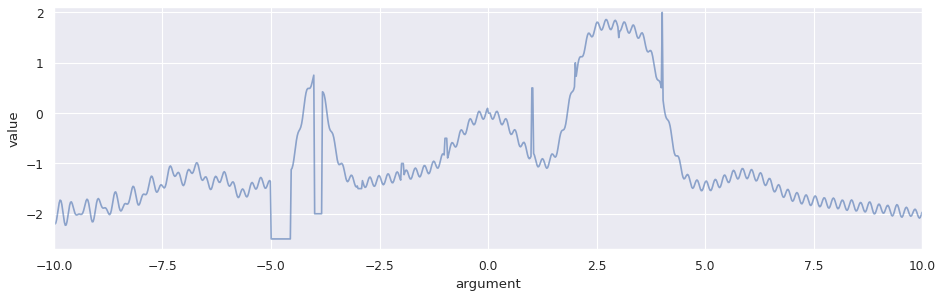

In [4]:
draw_F()

## Random search

In [5]:
class RandomSearch():
    def __init__(self, size = 100):
        self.p = np.random.uniform(-10, 10, size)
        self.j = J(self.p)
        self.best = self.p[np.argmax(self.j)]
        self.best_j = self.j[np.argmax(self.j)]

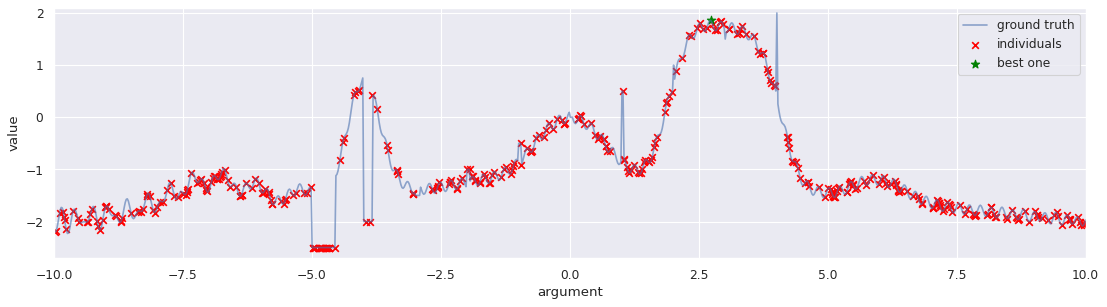

In [17]:
#@title Number of random points { run: "auto" }
SIZE = 388 #@param {type:"slider", min:1, max:1000, step:1}
np.random.seed(179)

rs = RandomSearch(size=SIZE)

draw_F()
plt.scatter(rs.p[rs.j < rs.best_j], rs.j[rs.j < rs.best_j], marker="x", color="red", label="individuals")
plt.scatter(rs.best, rs.best_j, marker="*", color="green", label="best one", s=60)
plt.legend()
plt.tight_layout()
plt.savefig("randomsearch.png", transparent=True)

## Simulated annealing

In [18]:
class Annealing():
    def __init__(self):
        self.p = np.random.uniform(-10, 10, size=(1,))
        self.j = J(self.p)
        self.temp = 1
        
    def start_step(self):
        self.candidate = self.p + 0.5 * np.random.normal()
        self.candidate_j = J(self.candidate)
        
        self.proba = min(1, np.exp((self.candidate_j - self.j) * self.temp))
        self.accepted = np.random.uniform(0, 1) < self.proba
        
    def finish_step(self):
        if self.accepted:
            self.p = self.candidate
            self.j = self.candidate_j
        self.temp += 1

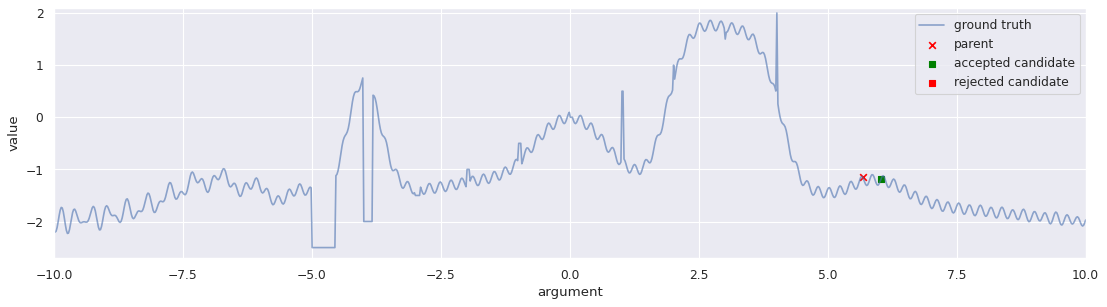

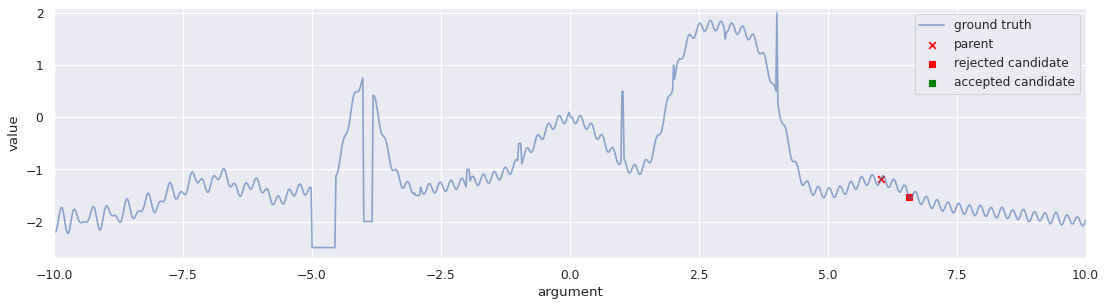

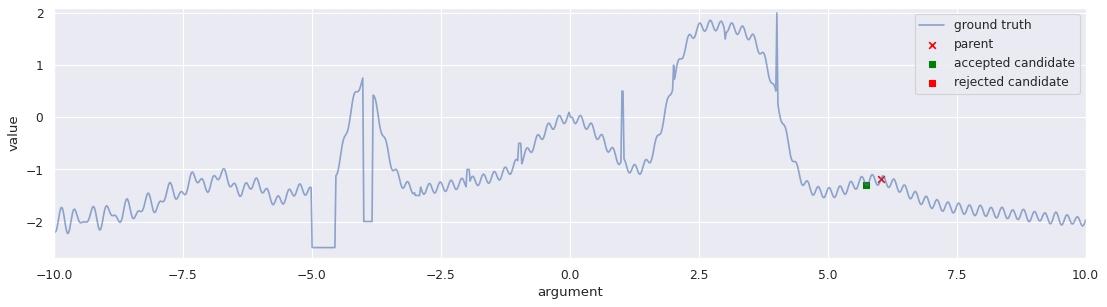

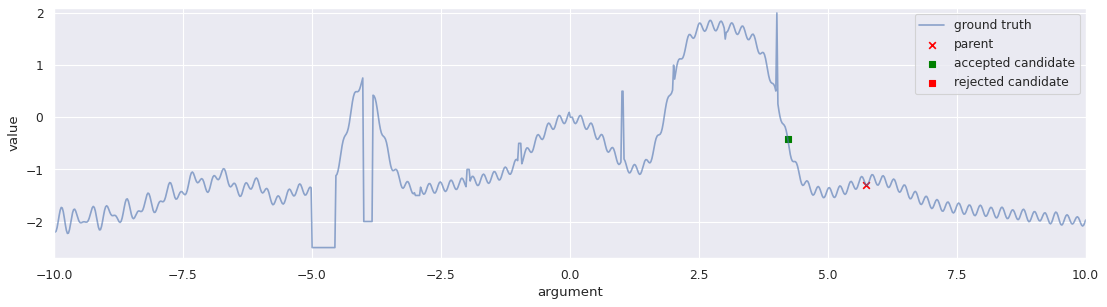

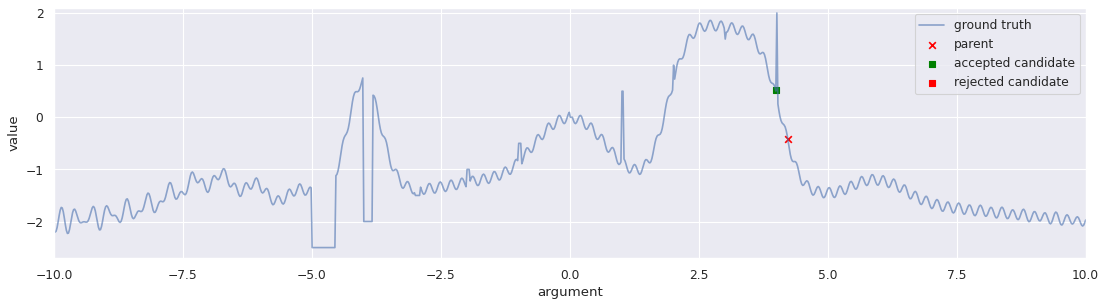

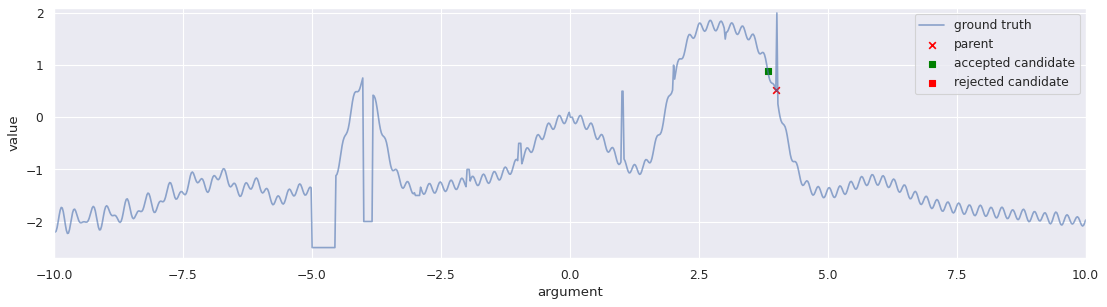

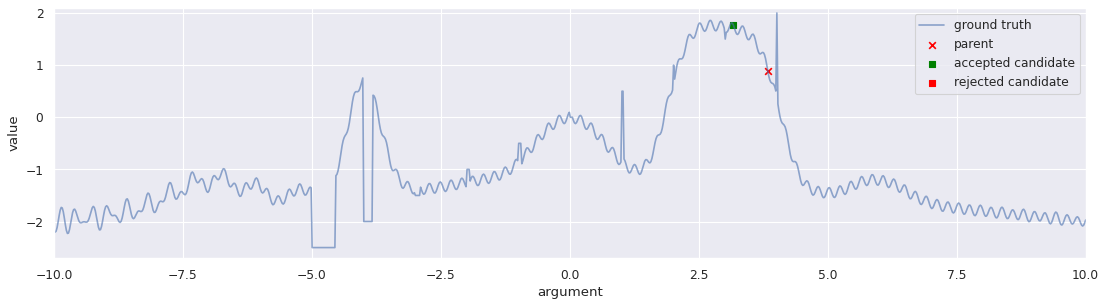

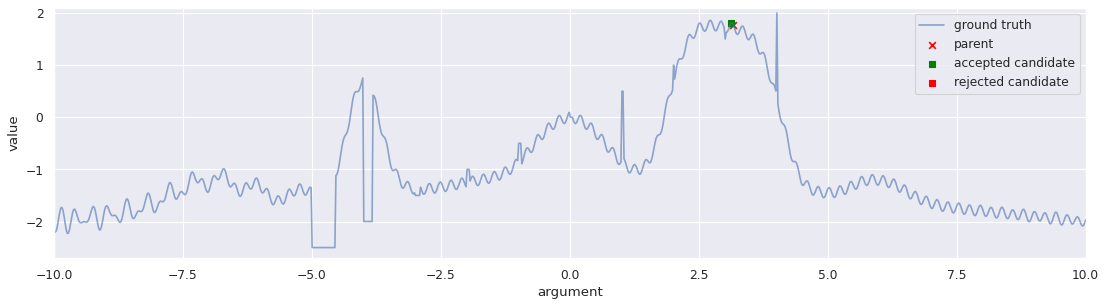

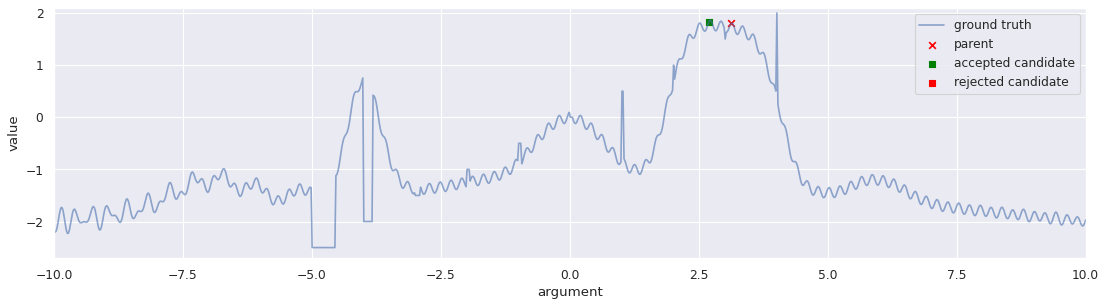

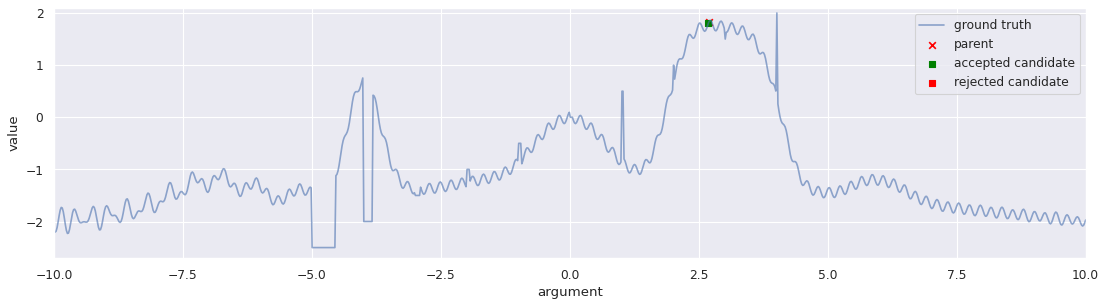

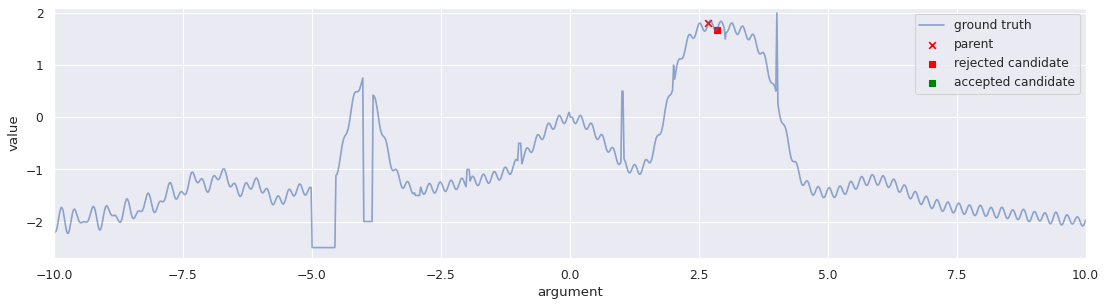

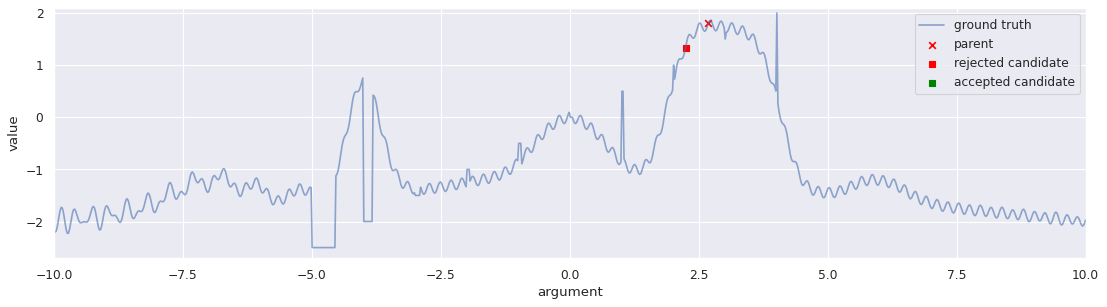

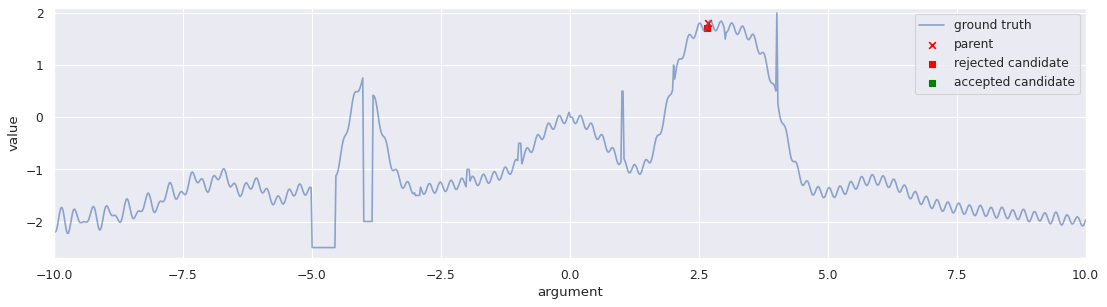

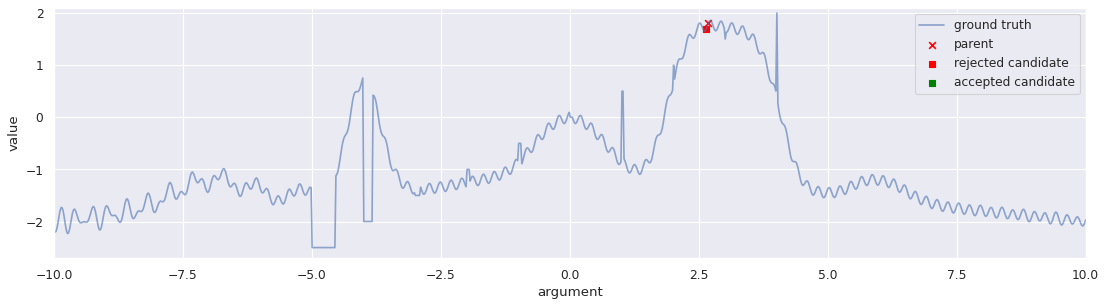

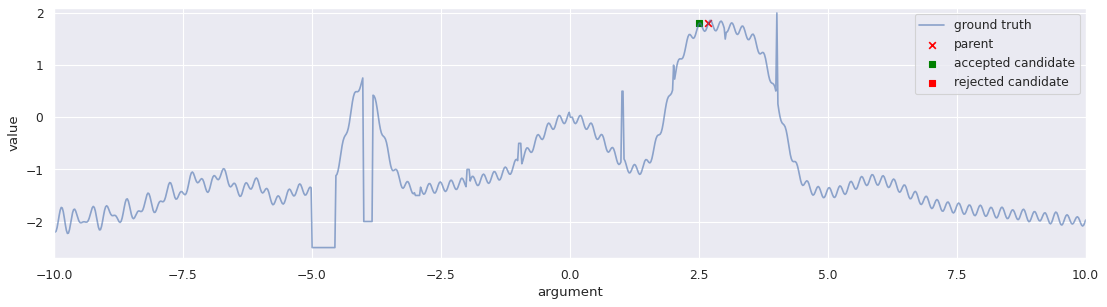

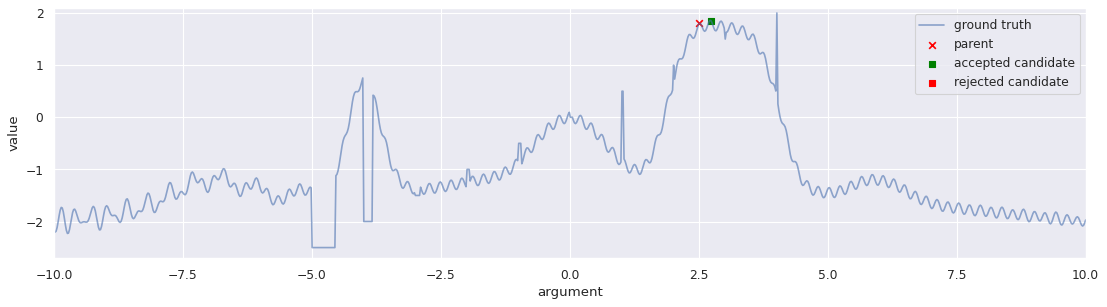

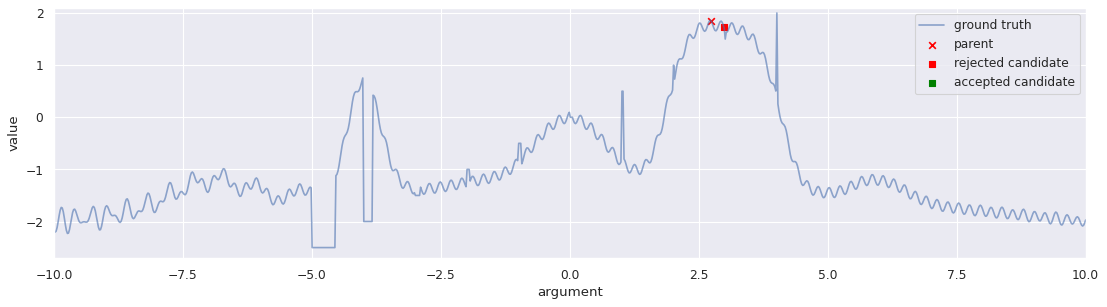

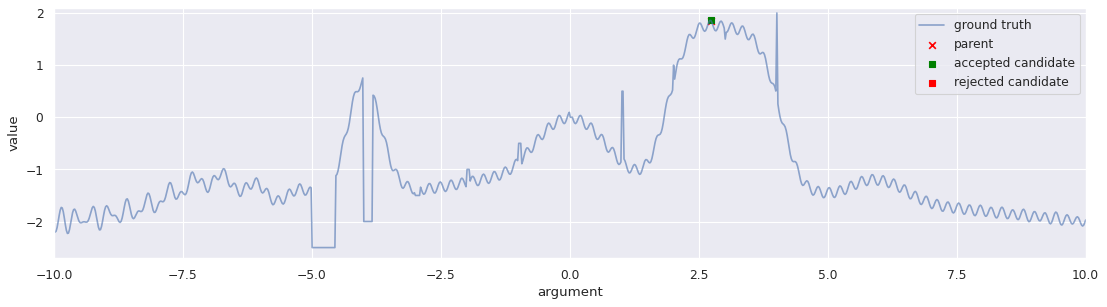

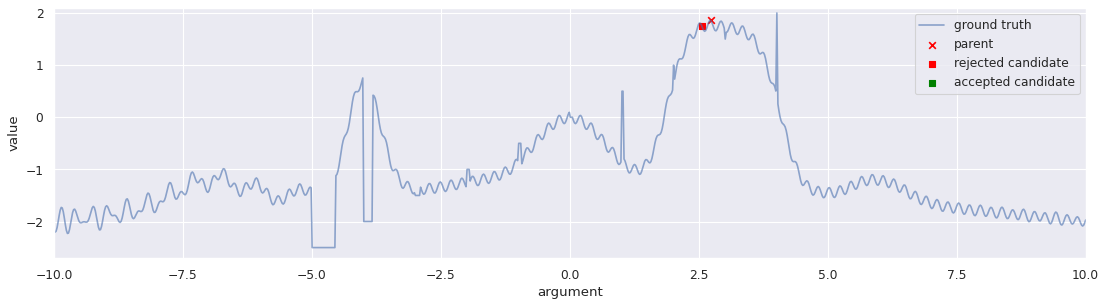

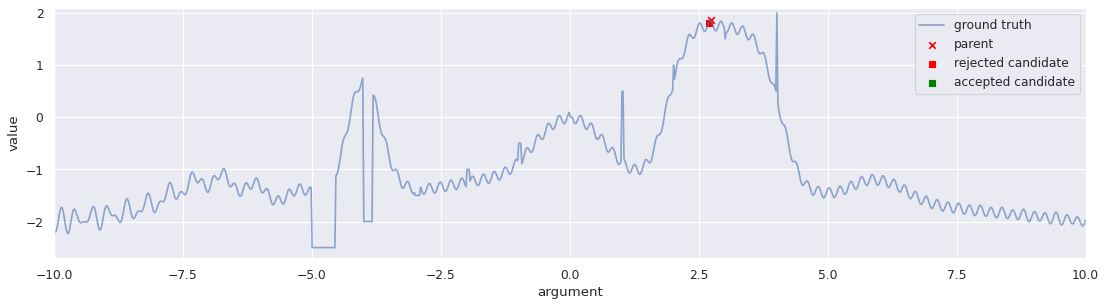

In [19]:
np.random.seed(46)
rs = Annealing()

for k in range(20):
    rs.start_step()
    draw_F()
    plt.scatter(rs.p, rs.j, marker="x", color="red", label="parent")
    if rs.accepted:
        plt.scatter(rs.candidate, rs.candidate_j, marker="s", color="green", label="accepted candidate")
        plt.scatter([], [], marker="s", color="red", label="rejected candidate")
    else:
        plt.scatter(rs.candidate, rs.candidate_j, marker="s", color="red", label="rejected candidate")
        plt.scatter([], [], marker="s", color="green", label="accepted candidate")
    rs.finish_step()
    plt.legend()
    plt.tight_layout()
    plt.savefig("simulated_annealing-" + str(k) + ".png", transparent=True)

## Hill Climbing

In [20]:
class HillClimbing():
    def __init__(self, M):
        self.p = np.random.uniform(-10, 10, size=(1,))
        self.j = J(self.p)
        self._M = M
        
    def start_step(self):
        self.candidate = self.p + 0.5 * np.random.normal(size=self._M)
        self.candidate_j = J(self.candidate)
        
    def finish_step(self):
        self.p = self.candidate[np.argmax(self.candidate_j)]
        self.j = np.max(self.candidate_j)

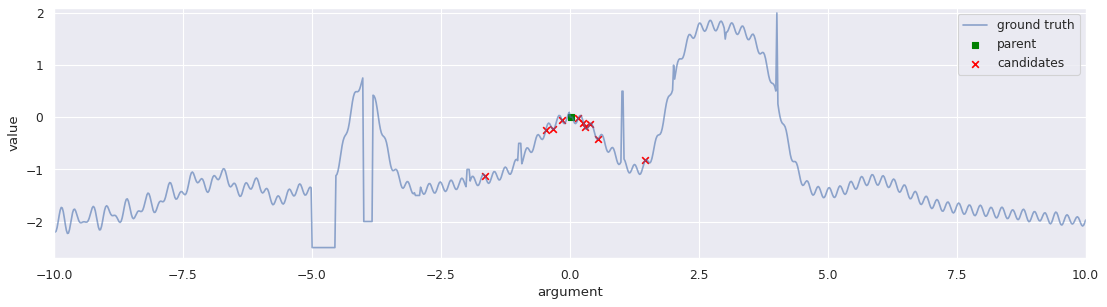

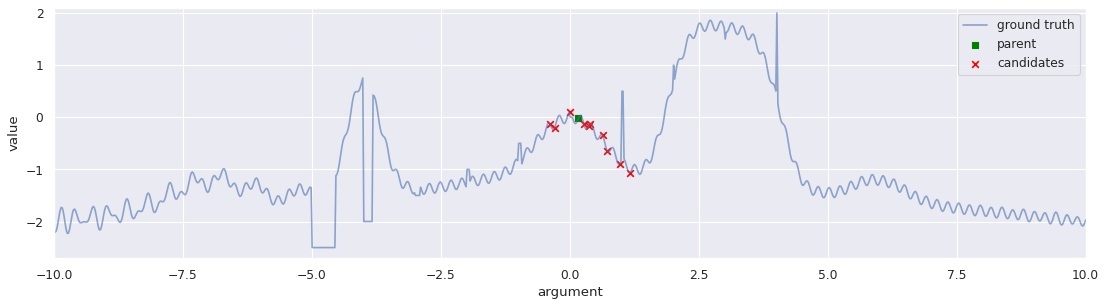

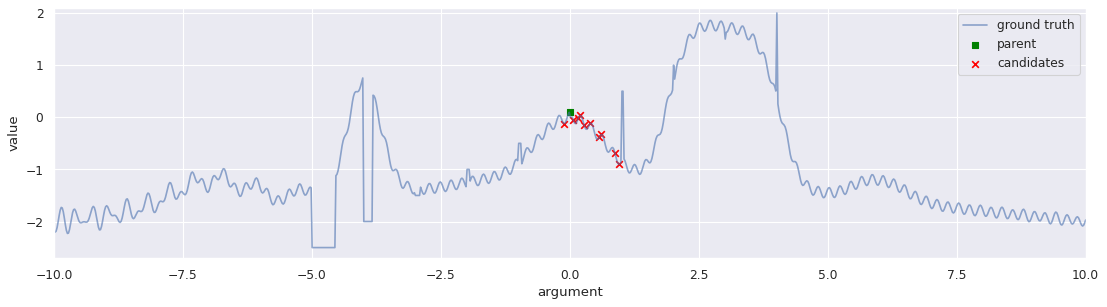

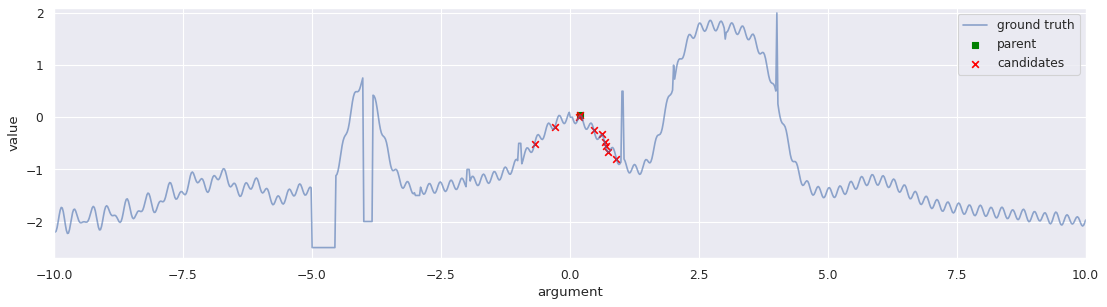

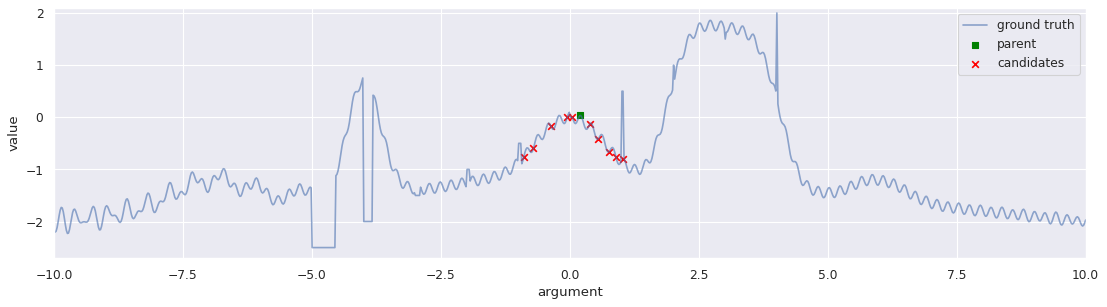

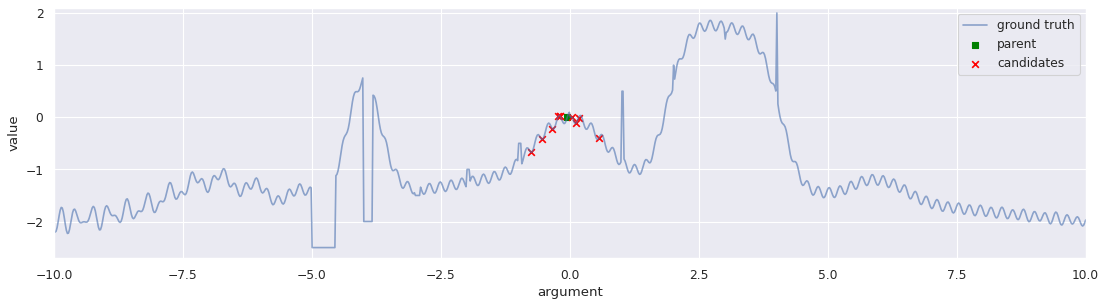

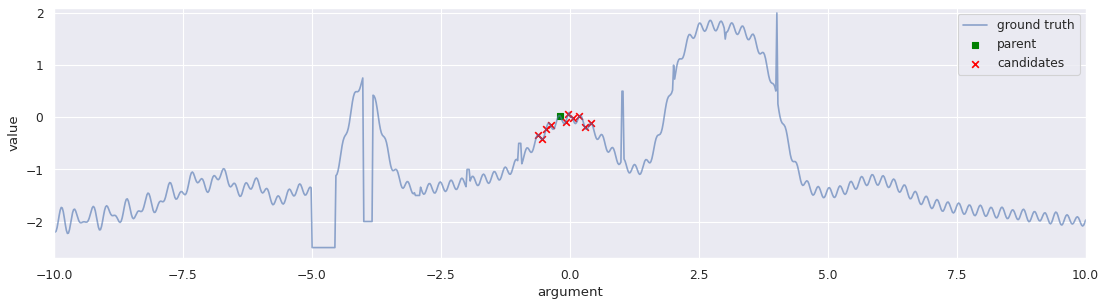

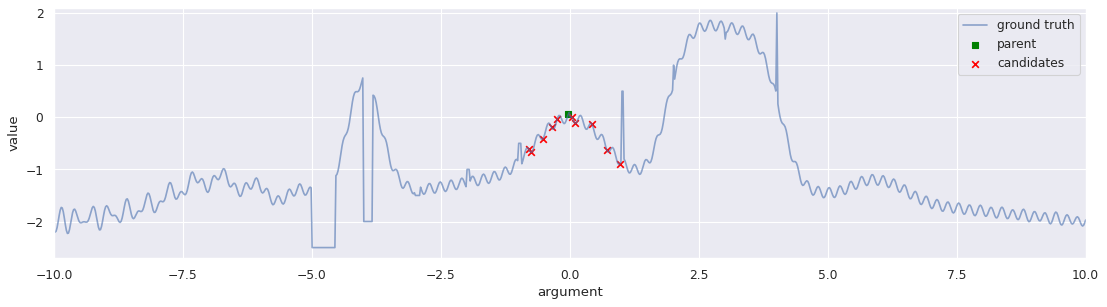

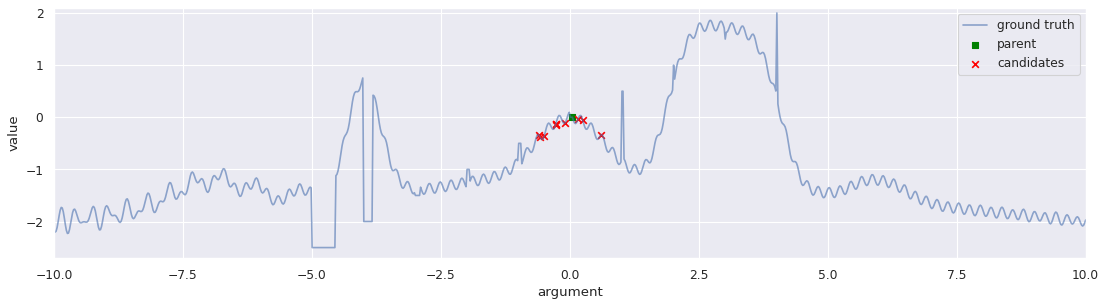

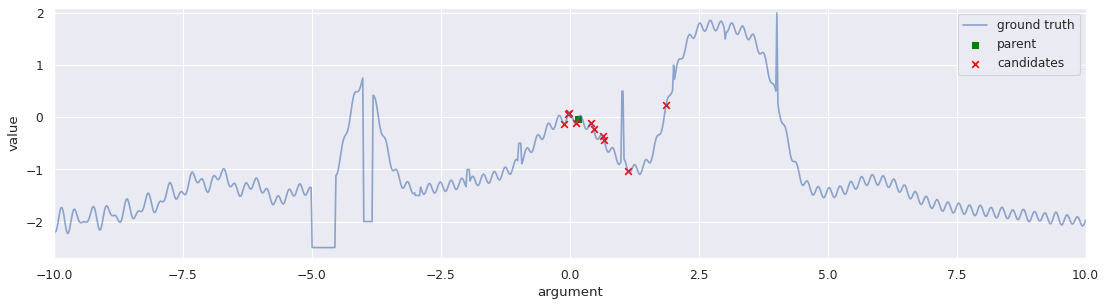

In [21]:
np.random.seed(79)
rs = HillClimbing(10)

for k in range(10):
    rs.start_step()
    draw_F()
    plt.scatter(rs.p, rs.j, marker="s", color="green", label="parent")
    plt.scatter(rs.candidate, rs.candidate_j, marker="x", color="red", label="candidates")
    rs.finish_step()
    plt.legend()
    plt.tight_layout()
    plt.savefig("hill_climbing-" + str(k) + ".png", transparent=True)

## Evolutionary strategy with $M$ threads and $N$ samples per thread

In [22]:
#@title Choose the number of threads M and the number of samples N { run: "auto" }
M = 10 #@param {type:"slider", min:1, max:10, step:1}
N = 10 #@param {type:"slider", min:1, max:10, step:1}

class MS_ES():
    def __init__(self, threads=M, samples_per_thread=N):
        self.p = np.random.uniform(-10, 10, size=(threads,))
        self.j = J(self.p)
        self.threads = threads
        self.samples_per_thread = samples_per_thread
        
    def start_step(self):
        self.candidate = (self.p + 0.5 * np.random.normal(size=(self.samples_per_thread, self.threads))).flatten()
        self.candidate_j = J(self.candidate)
        
    def finish_step(self):
        self.thr = np.sort(self.candidate_j)[-self.threads]
        self.p = self.candidate[self.candidate_j >= self.thr]
        self.j = self.candidate_j[self.candidate_j >= self.thr]
        assert self.p.shape == (self.threads,)

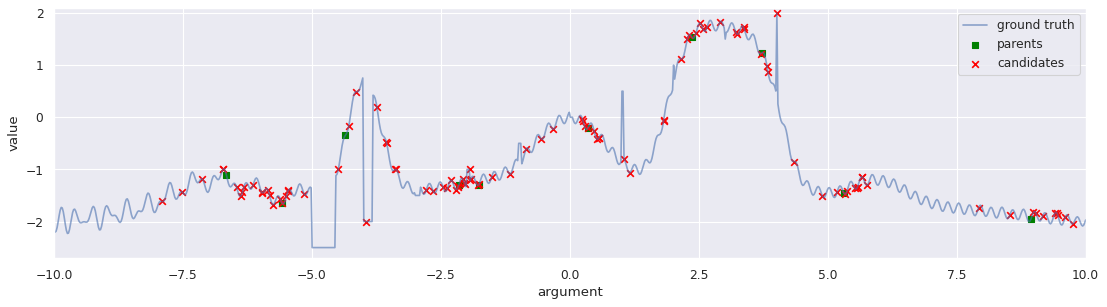

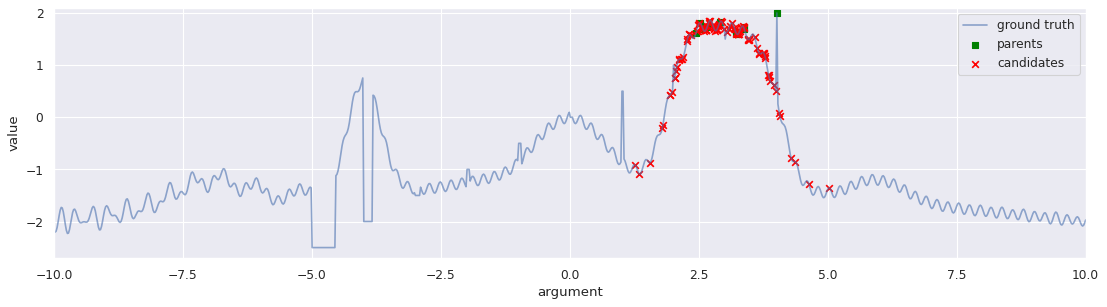

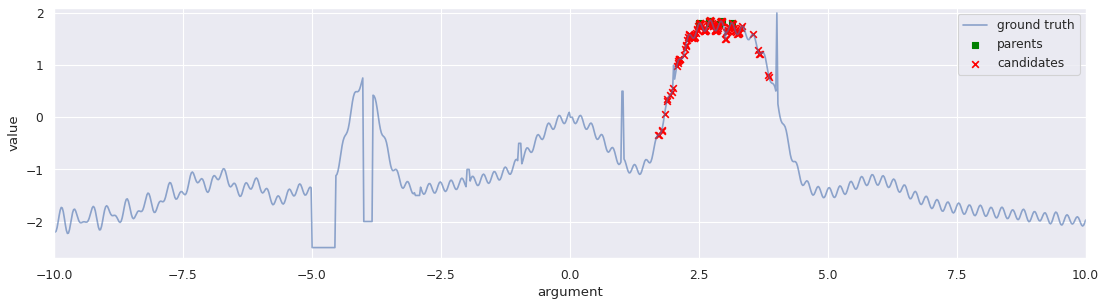

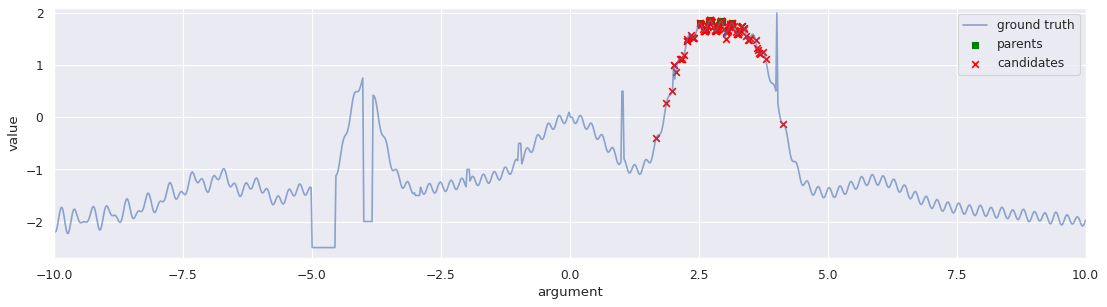

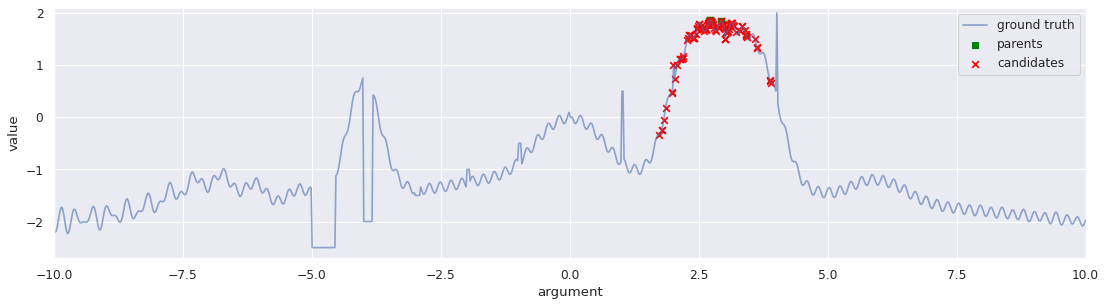

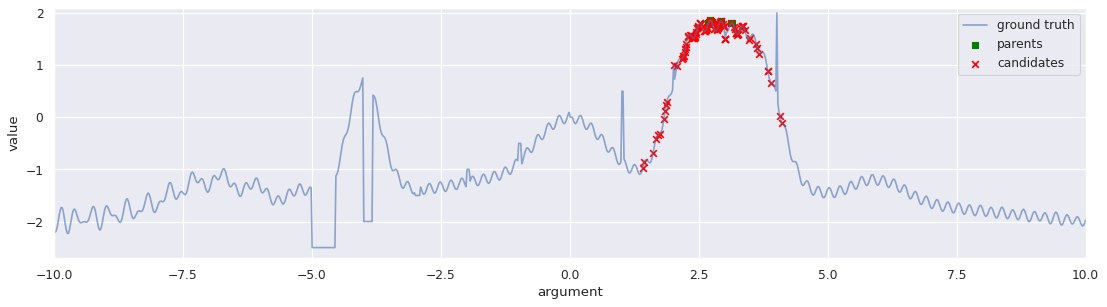

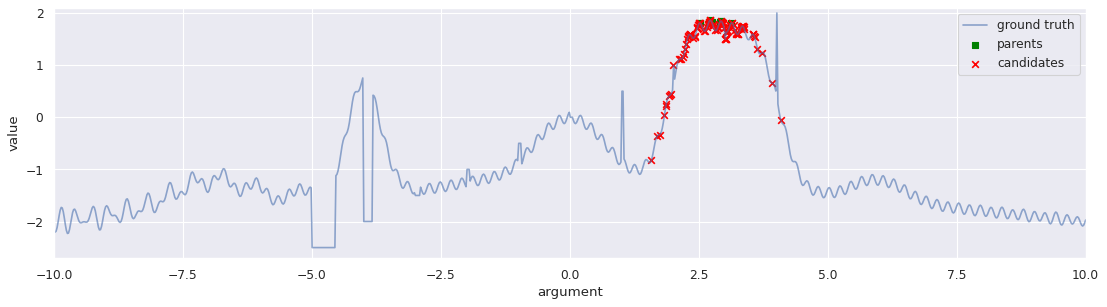

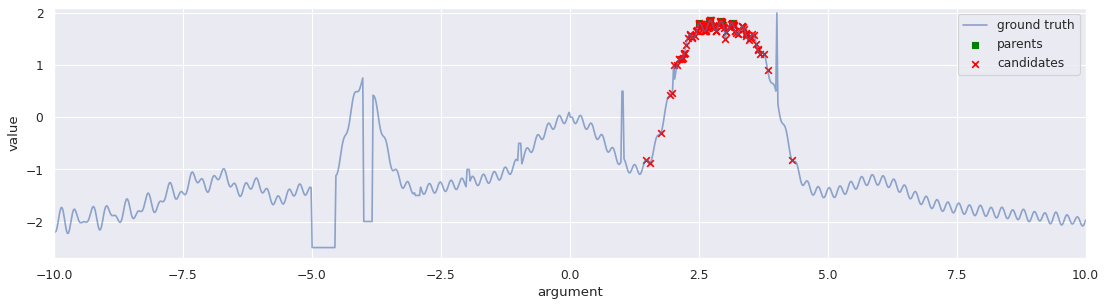

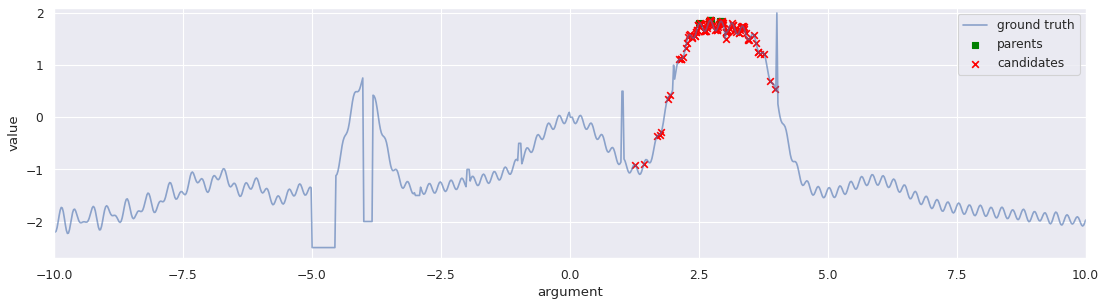

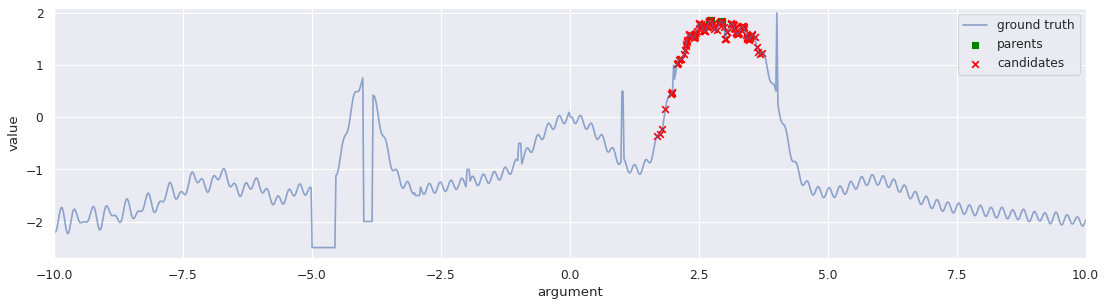

In [23]:
np.random.seed(23)
rs = MS_ES(M,N)

for k in range(10):
    rs.start_step()
    draw_F()
    plt.scatter(rs.p, rs.j, marker="s", color="green", label="parents")
    plt.scatter(rs.candidate, rs.candidate_j, marker="x", color="red", label="candidates")
    rs.finish_step()
    plt.legend()
    plt.tight_layout()
    plt.savefig("ms_es-" + str(k) + ".png", transparent=True)

## Evolutionary strategy with spicies

In [24]:
import numpy as np
from numpy.random import shuffle, choice

class Elitism():
    def __init__(self):
        self.p = np.random.uniform(-10, 10, size=(4,))
        self.j = J(self.p)
        self.reproduce = [5,5,5,5]
        
    def start_step(self):
        self.candidate = np.concatenate([self.p[i] + 0.5 * np.random.normal(size=(self.reproduce[i])) for i in range(len(self.p))])
        self.candidate_j = J(self.candidate)
        
    def split(self):
        indexes = np.arange(20)
        shuffle(indexes)
        self.species = []
        
        for i in indexes:
            c = self.candidate[i]
            
            shuffle(self.species)
            for s in self.species:
                representative = self.candidate[choice(list(s))]
                if np.abs(representative - c) < 1:
                    s.add(i)
                    break
            else:
                self.species.append({i})
                
        self.species_j = []
        for s in self.species:
            self.species_j.append(np.array([self.candidate_j[i] for i in s]).mean())
        
        p = np.exp(self.species_j)
        p /= p.sum()
        self.reproduce = np.bincount(choice(np.arange(len(self.species)), p=p, size=20), minlength=len(self.species))
        
    def finish_step(self):
        self.p = []
        self.j = []
        for s in self.species:
            s = list(s)
            best = np.argmax([self.candidate_j[i] for i in s])
            self.p.append(self.candidate[s[best]])
            self.j.append(self.candidate_j[s[best]])

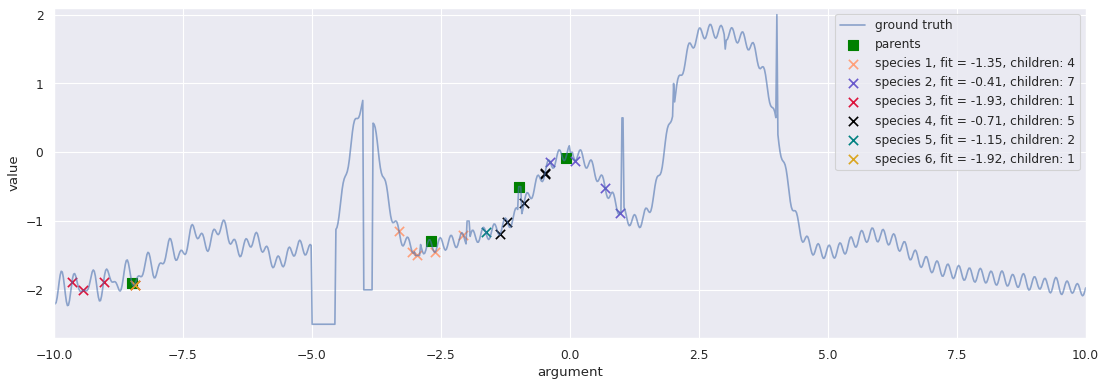

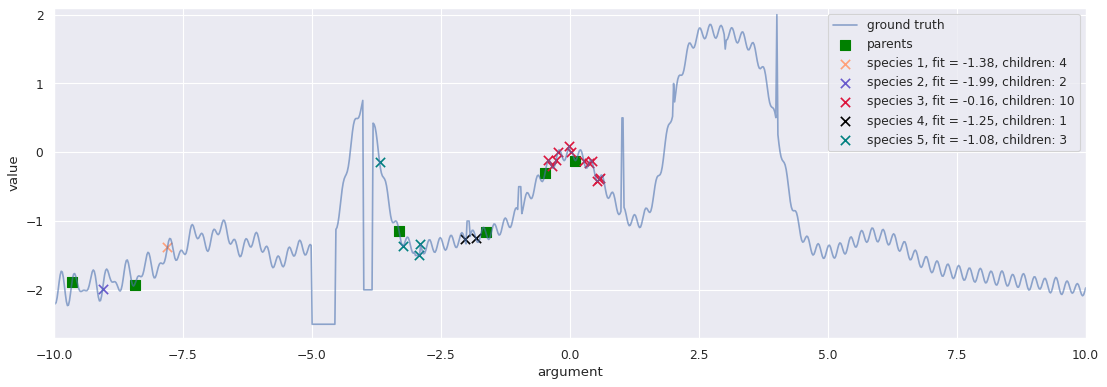

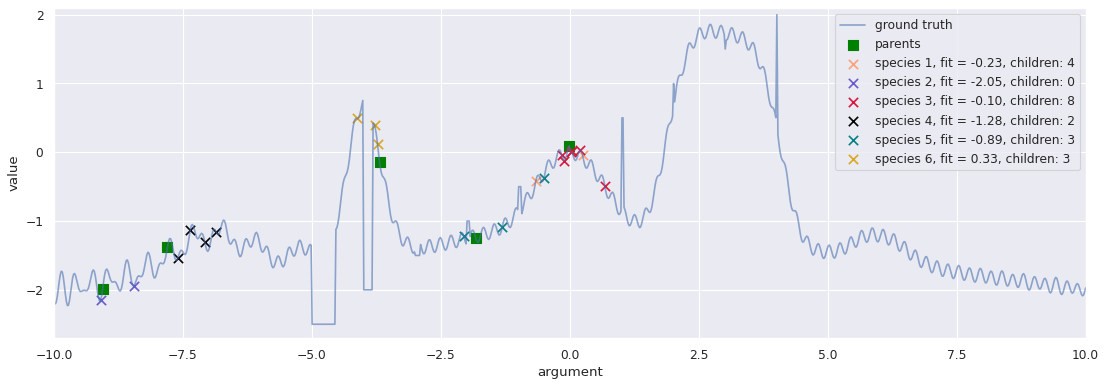

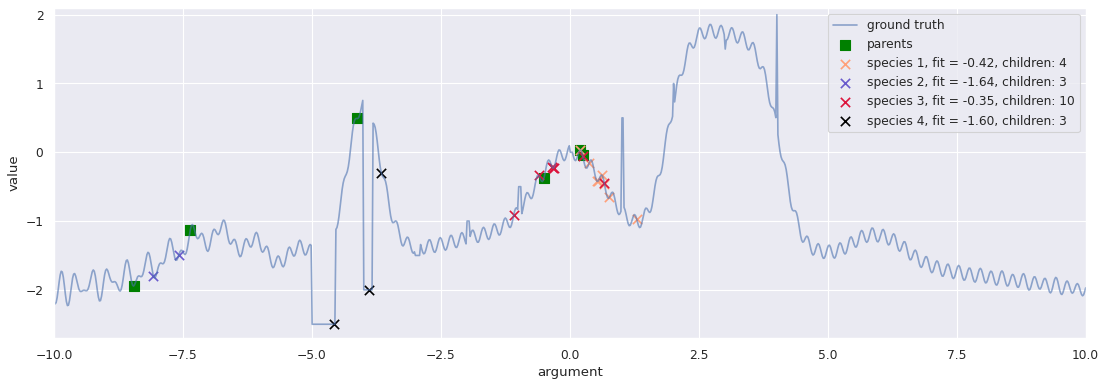

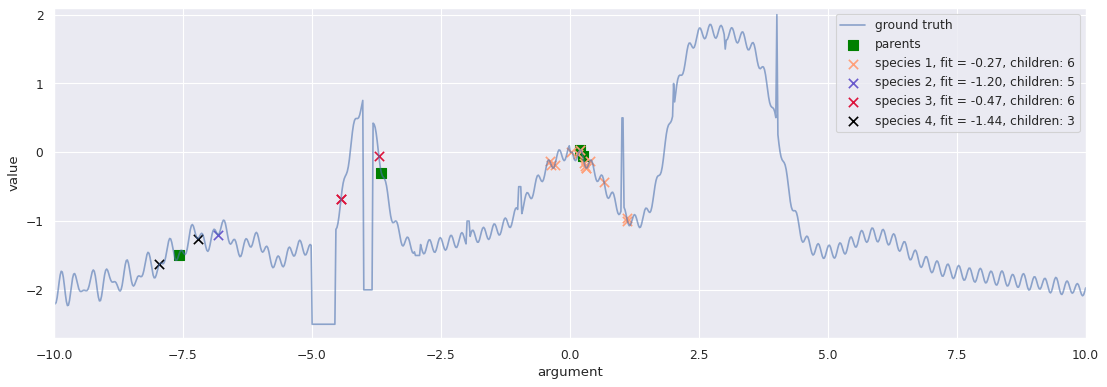

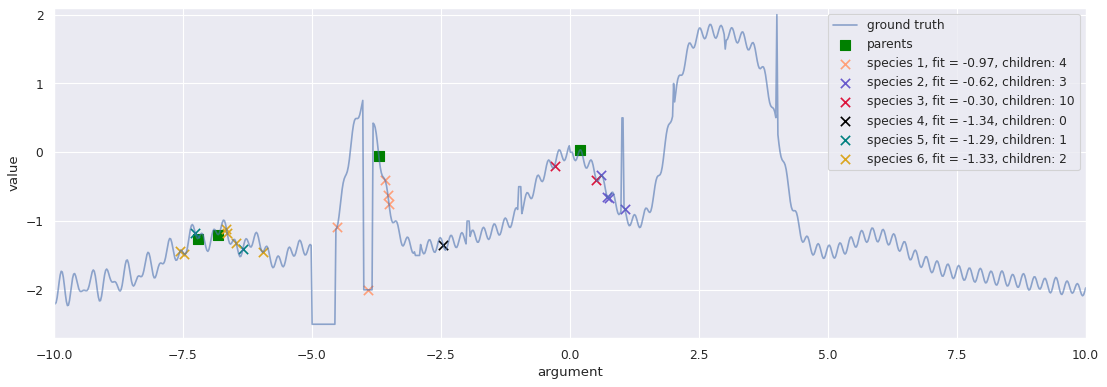

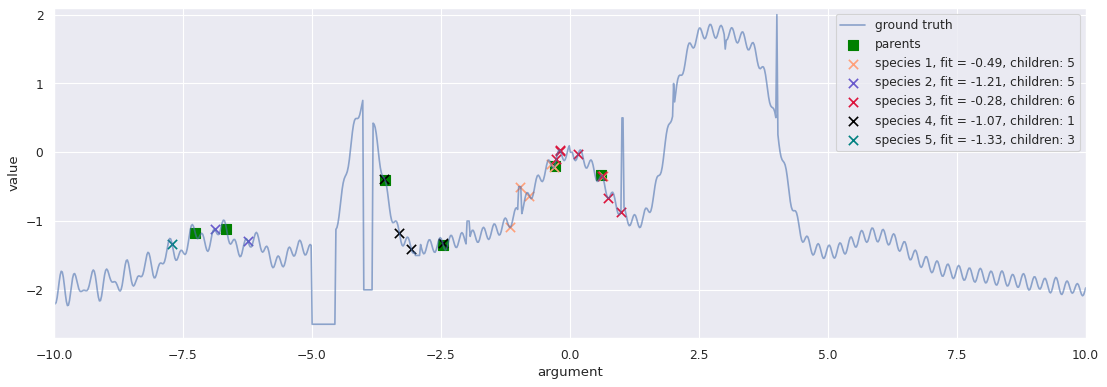

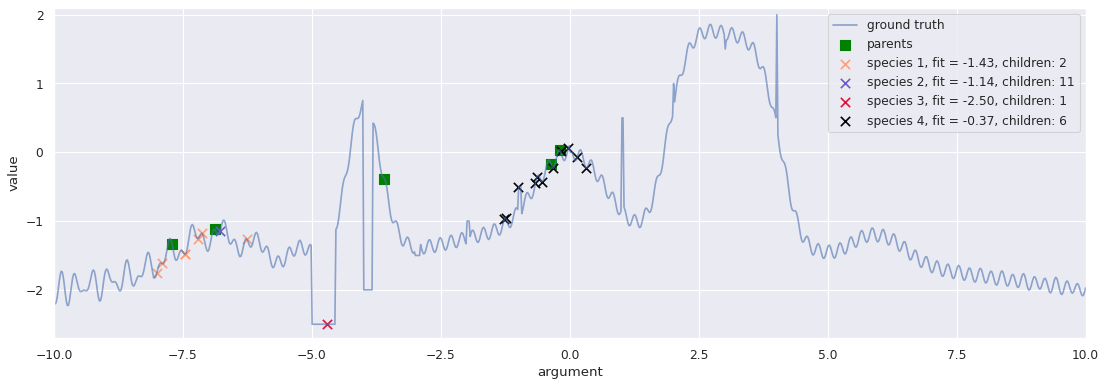

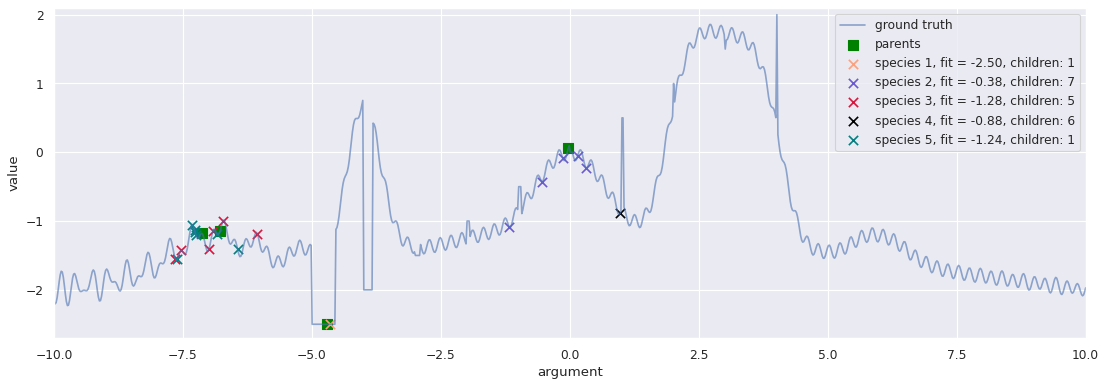

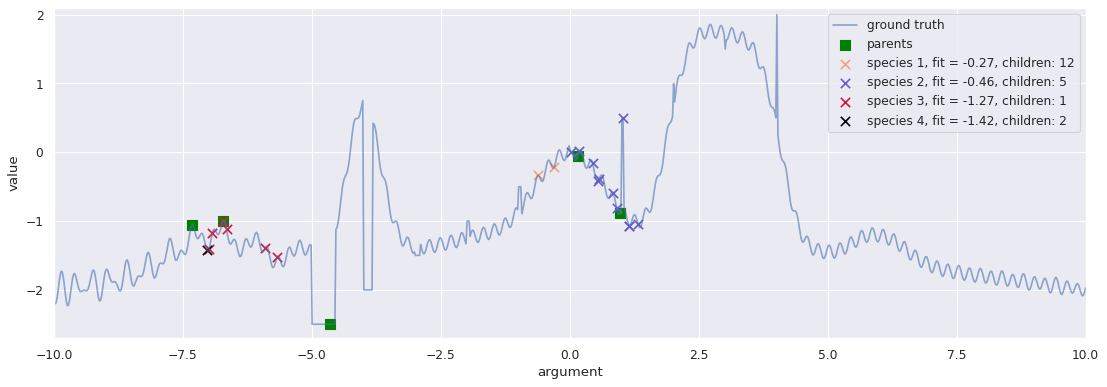

In [25]:
np.random.seed(58)
el = Elitism()
for epoch in range(10):
    el.start_step()
    draw_F((14,5))
    plt.scatter(el.p, el.j, marker="s", color="green", label="parents", s=70)

    el.split()
    colors = ["lightsalmon", "slateblue", "crimson", "black", "teal", "goldenrod", "magenta", "brown"]
    for k in range(len(el.species)):
        color = colors[k]
        candidate = [el.candidate[i] for i in el.species[k]]
        candidate_j = [el.candidate_j[i] for i in el.species[k]]
        plt.scatter(candidate, candidate_j, marker="x", color=color, s=70,
                    label=f"species {k+1}, fit = " + "{:.2f}".format(el.species_j[k]) + f", children: {el.reproduce[k]}")

    el.finish_step()
    plt.legend()
    plt.tight_layout()
    plt.savefig("el_es-" + str(epoch) + ".png", transparent=True)

## Evolutionary sampling with fixed variance

In [26]:
class ES():
    def __init__(self, M):
        self.p = np.random.uniform(-10, 10, size=(1,))
        self.j = J(self.p)
        self._M = M
        
    def start_step(self):
        self.candidate = self.p + np.random.normal(size=self._M)
        self.candidate_j = J(self.candidate)
        
    def finish_step(self):
        self.p = self.p + 1 * ((self.candidate - self.p) * self.candidate_j).mean()
        self.j = J(self.p)

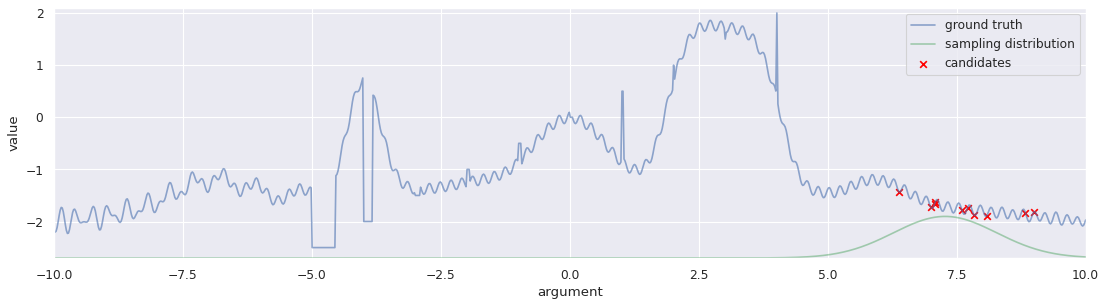

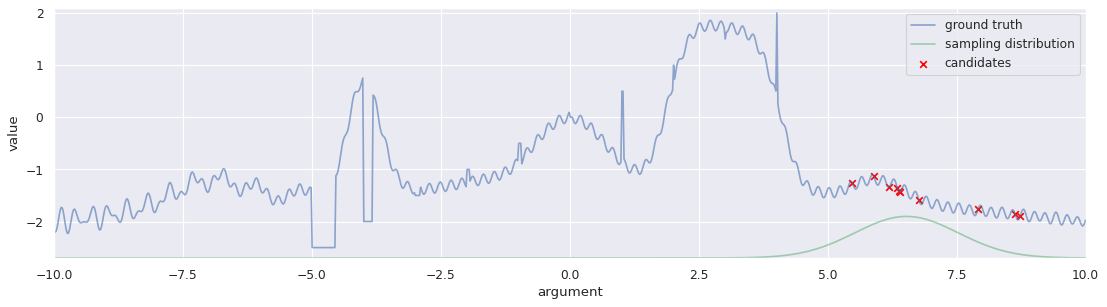

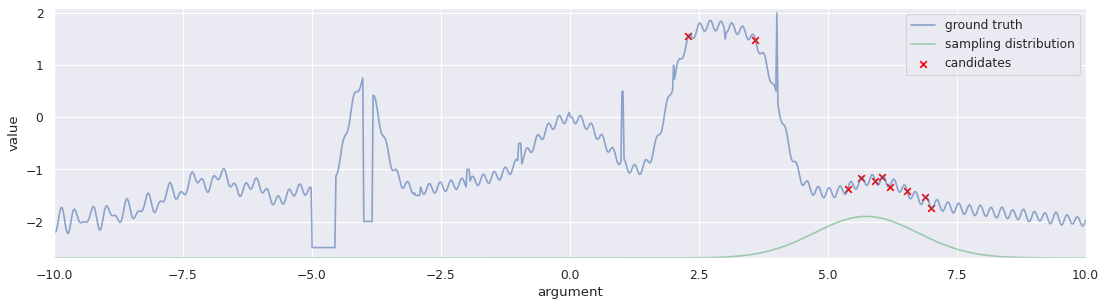

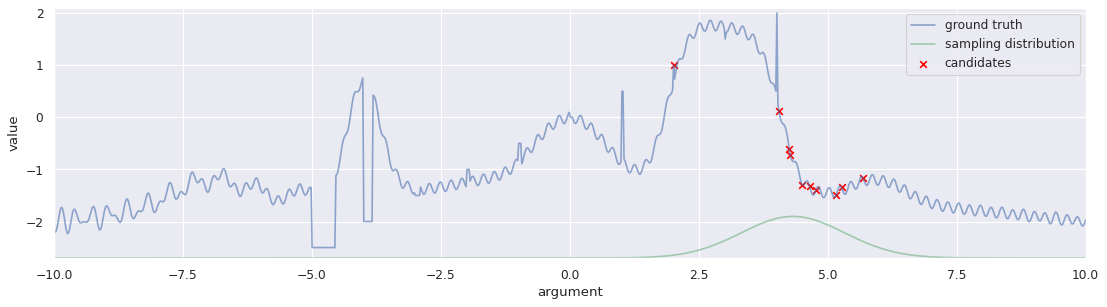

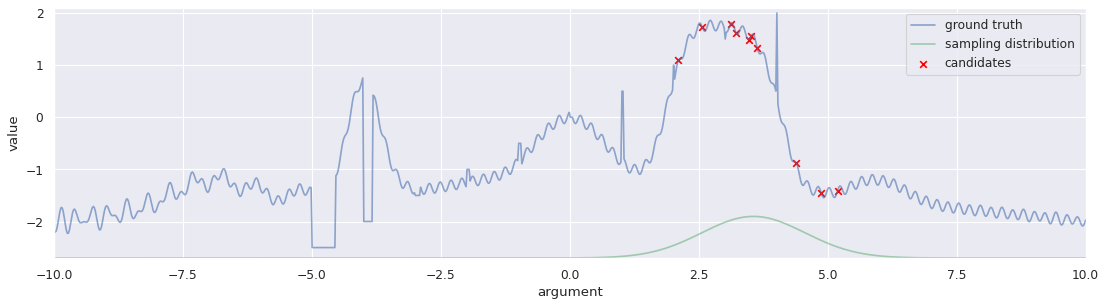

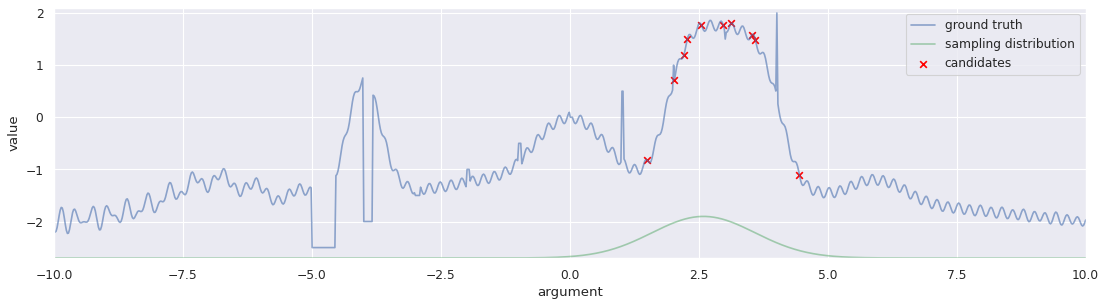

In [27]:
from scipy.stats import norm

np.random.seed(29)
rs = ES(10)

for k in range(6):
    rs.start_step()
    draw_F()
    
    x = np.linspace(-10, 10, 1000)
    plt.plot(x, 2*norm(rs.p).pdf(x) - 2.7, color='g', alpha=0.5, label="sampling distribution")
    
    plt.scatter(rs.candidate, rs.candidate_j, marker="x", color="red", label="candidates")
    rs.finish_step()
    
    plt.legend()
    plt.tight_layout()
    plt.savefig("es-" + str(k) + ".png", transparent=True)

## Covariance Matrix Adaptation Evolutionary Sampling 

In [28]:
class CMA_ES():
    def __init__(self, M):
        self.p = np.random.uniform(-10, 10, size=(1,))
        self.j = J(self.p)
        self._M = M
        self.cov = 1
        
    def start_step(self):
        self.candidate = self.p + (self.cov**0.5) * np.random.normal(size=self._M)
        self.candidate_j = J(self.candidate)
        
    def finish_step(self):
        self.cov = self.cov + 0.5 * (((self.candidate - self.p)**2 - self.cov) * self.candidate_j).mean()
        self.p = self.p + 1 * ((self.candidate - self.p) * self.candidate_j).mean()
        self.j = J(self.p)

1
1.1875849768196687
0.6964123275445279
1.609567225432646
1.9879344489932795
1.487191754316028
0.6435644220335756
0.2689781187994286
0.14338688561383595
0.07260222667599706


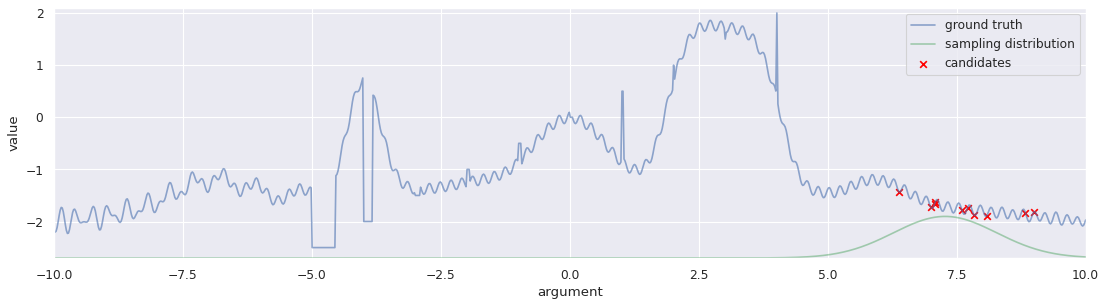

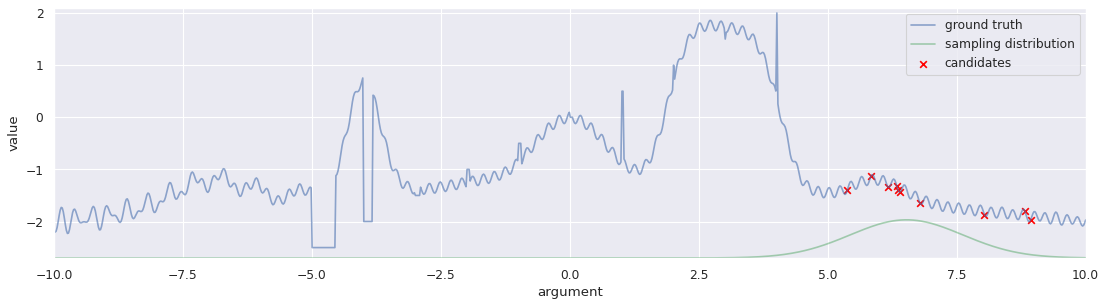

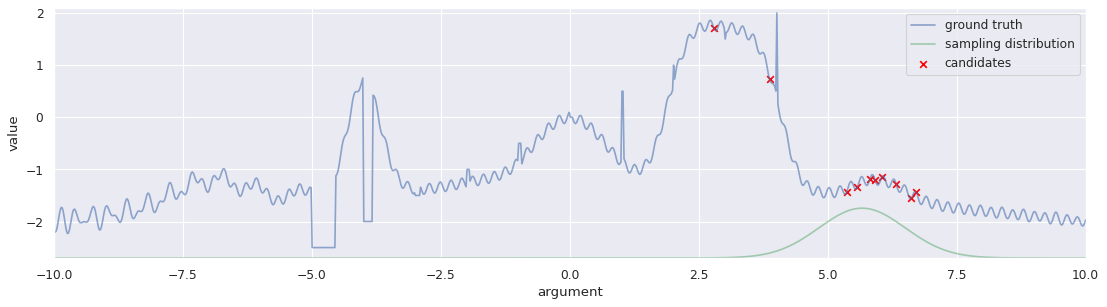

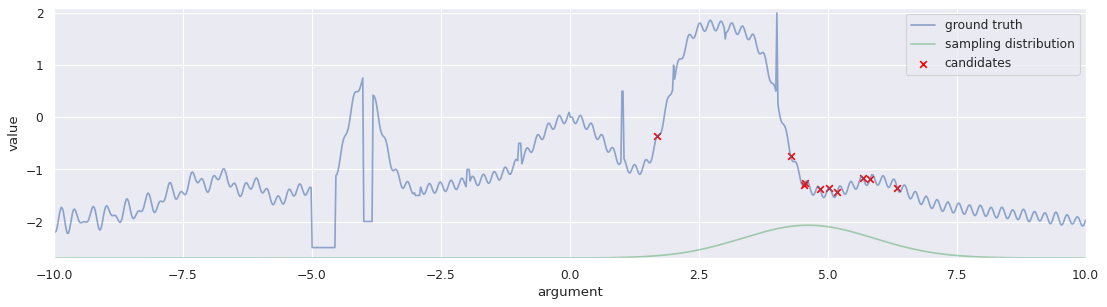

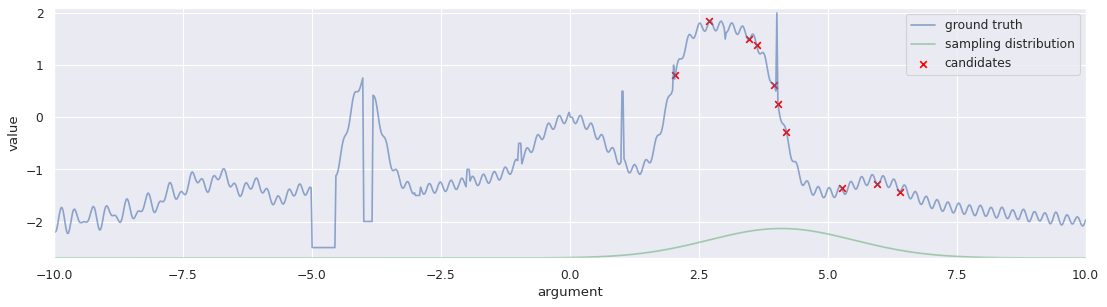

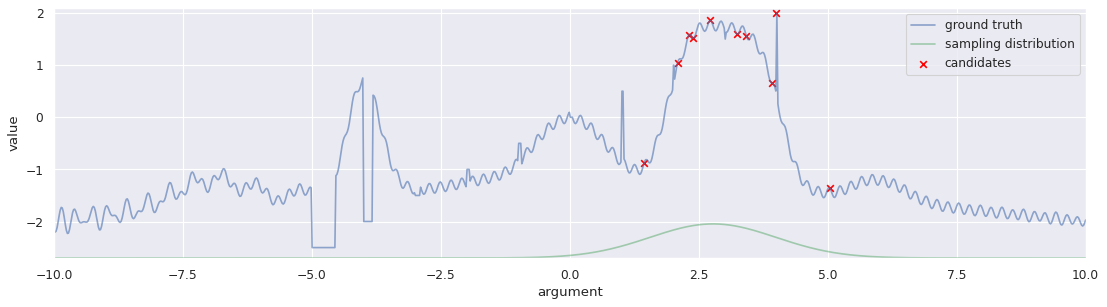

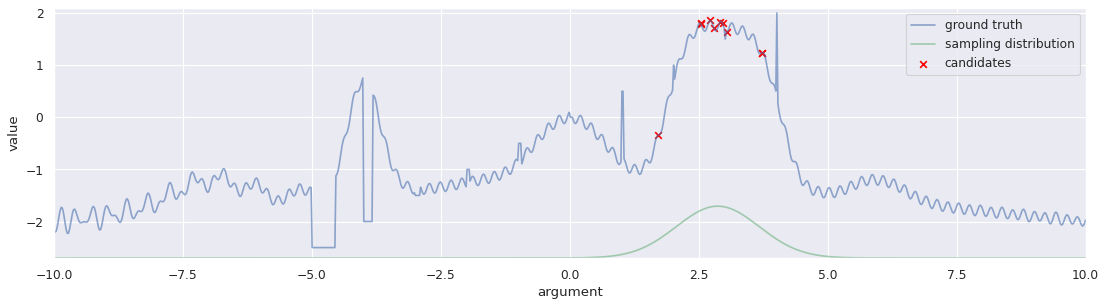

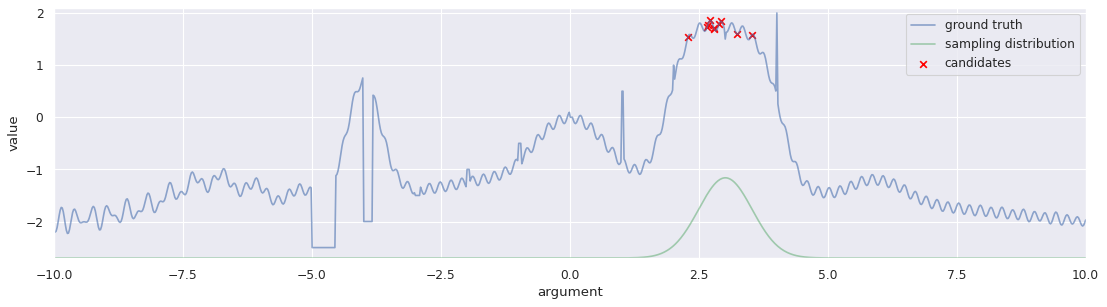

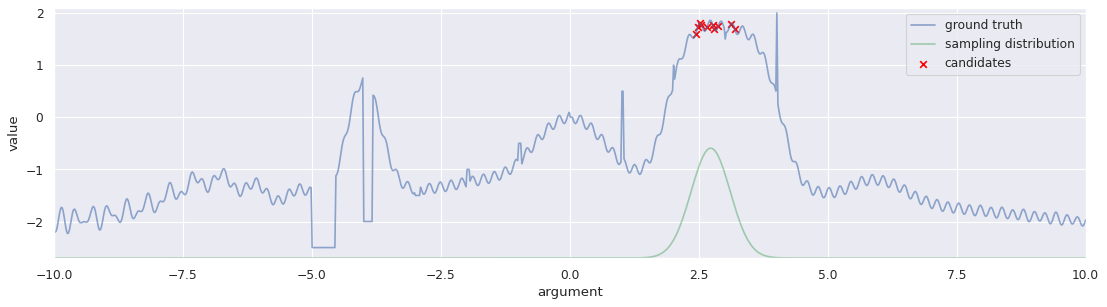

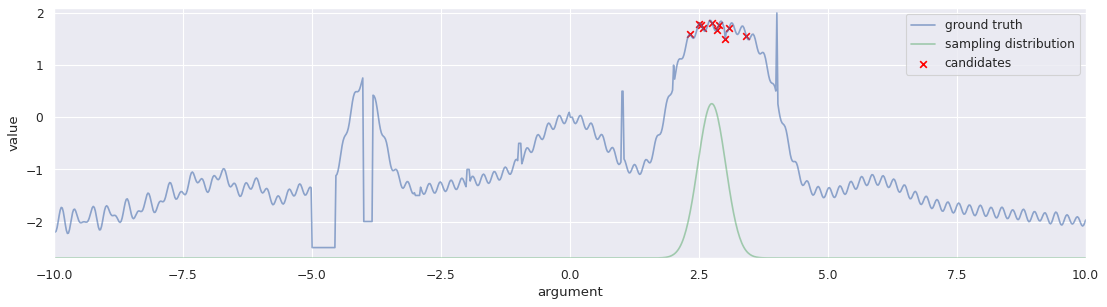

In [29]:
from scipy.stats import norm

np.random.seed(29)
rs = CMA_ES(10)

for k in range(10):
    print(rs.cov)
    rs.start_step()
    draw_F()
    
    x = np.linspace(-10, 10, 1000)
    plt.plot(x, 2*norm(rs.p, rs.cov**0.5).pdf(x) - 2.7, color='g', alpha=0.5, label="sampling distribution")
    
    plt.scatter(rs.candidate, rs.candidate_j, marker="x", color="red", label="candidates")
    rs.finish_step()
    
    plt.legend()
    plt.tight_layout()
    plt.savefig("cma_es-" + str(k) + ".png", transparent=True)

# Materials
The code for plotting this was initially taken from the author of [this book](https://github.com/FortsAndMills/RL-Theory-book)